In [5]:
import networkx as nx
import numpy as np
import itertools as it
import random
import pandas as pd
import numpy as np
import math

# 1. Introduction to the problem

## Creating problem configuration

In [6]:
def get_grid_graph(routers_placement: np.array, backbone_unit_cost: int):
    # creating the equivalent grid graph for the routers placement
	n, m = routers_placement.shape
	g = nx.grid_2d_graph(n, m)

	# adding edges to the graph
	g.add_edges_from(
		[
			((x, y), (x + 1, y + 1))
			for x in range(n-1)
			for y in range(m-1)
		] +
		[
			((x + 1, y), (x, y + 1))
			for x in range(n-1)
			for y in range(m-1)
		],
		weight=backbone_unit_cost
	)

	return g

In [7]:
def generate_random_router_configuration(shape, n_routers):
    n, m = shape
    routers_placement = np.zeros(shape)
    routers_coords = set()
    
    while len(routers_coords) != n_routers:
        row = random.randint(0, n-1)
        column = random.randint(0, m-1)
        if routers_placement[row][column] == 0:
            routers_placement[row][column] = 1
            routers_coords.add((row, column))
    
    return routers_placement, routers_coords

In [8]:
matrix_size = (30,30)
n_routers = 12
backbone_unit_cost = 4
routers_placement, routers_coords = generate_random_router_configuration(matrix_size, n_routers)
initial_backbone = routers_coords.pop() # using a random generated point as backbone

In [9]:
g = get_grid_graph(routers_placement, backbone_unit_cost)

## Finding Steiner tree by approximation

In [6]:
%%time
steiner_tree_approx_g = nx.approximation.steiner_tree(g, [ _ for _ in it.chain(routers_coords, {initial_backbone})])

CPU times: user 9.66 s, sys: 196 ms, total: 9.86 s
Wall time: 9.89 s


## Finding Steiner tree by heuristic

In [12]:
def get_chebyshev_distance(point1: tuple, point2: tuple):
	x1, y1 = point1
	x2, y2 = point2
	return max(abs(x1 - x2), abs(y1 - y2))

In [24]:
def single_objective_a_star(
    original_g, 
    routers_coords, 
    backbone_starting_point, 
    backbone_unit_cost
):
    g = nx.Graph(original_g)
    
    # setting the weight of each edge to the cost of a backbone unit
    for edge in g.edges():
        g.edges()[edge]["weight"] = backbone_unit_cost

    # for each router, searching the shortest path
    for router in routers_coords:
        # use a-star to found the shortest past
        path = nx.astar_path(
            g,
            backbone_starting_point,
            router,
            heuristic=get_chebyshev_distance,
            weight="weight"
        )
        # reducing the cost of found edges
        for path_edge in it.pairwise(path):
            g.edges()[path_edge]["weight"] = 0

    # cutting off the edges not used
    edges_to_remove = [edge for edge in g.edges() if g.edges()[edge]["weight"] != 0]
    g.remove_edges_from(edges_to_remove)

    # cutting off nodes with degree zero
    nodes_to_remove = [node for node in g.nodes() if g.degree[node] == 0]
    g.remove_nodes_from(nodes_to_remove)

    return g

In [9]:
%%time
heuristic_g = single_objective_a_star(g, routers_coords, initial_backbone, backbone_unit_cost)

CPU times: user 54.6 ms, sys: 113 µs, total: 54.7 ms
Wall time: 53.6 ms


## Comparing results

In [10]:
def is_valid(g, terminals_coords):
    for (source, target) in it.combinations(terminals_coords, 2):
        if nx.has_path(g, source, target) == False:
            return False
    return True

In [11]:
heuristic_weight = len(heuristic_g.edges()) * backbone_unit_cost
approx_weight = len(steiner_tree_approx_g.edges()) * backbone_unit_cost
terminals_coords = [_ for _ in it.chain(routers_coords, {initial_backbone})]

In [12]:
print(f"Heuristic total weight: {heuristic_weight}")
print(f"Heuristic correctness: {is_valid(heuristic_g, terminals_coords)}")
print(f"Approximation total weight: {approx_weight}")
print(f"Approximation correctness: {is_valid(steiner_tree_approx_g, terminals_coords)}")

Heuristic total weight: 296
Heuristic correctness: True
Approximation total weight: 356
Approximation correctness: True


# 2. A more methodical approach 

## Assessing A* stability

### Variance for multiple runs on the same configuration

Assessing if there is any variance when the algorithm is perfomed multiple times on the same configuration. Our empirical approach shows how there is no variance for multiple runs on the same configuration, suggesting the determinism of the heuristic.

In [14]:
# creating a set of configurations to test   
n_configurations = 5
n_run_per_configuration = 10

matrix_size = (30,30)
n_routers = 12
backbone_unit_cost = 4

all_results = [] # all run results for each configuration
configurations = ( generate_random_router_configuration(matrix_size, n_routers) for _ in range(n_configurations) )
for (routers_placement, routers_coords) in configurations:
    initial_backbone = routers_coords.pop()
    g = get_grid_graph(routers_placement, backbone_unit_cost) # generating grid graph
    
    # run each configuration 
    configuration_results = []
    for _ in range(n_run_per_configuration):
        # finding steiner tree 
        heuristic_g = single_objective_a_star(g, routers_coords, initial_backbone, backbone_unit_cost)
        # saving the steiner tree weight of this run 
        configuration_results.append(len(heuristic_g.edges())*backbone_unit_cost)
    
    all_results.append(configuration_results)

In [15]:
stability_df = pd.DataFrame(
    np.array(all_results).T, 
    columns = [f"Configuration #{index} runs" for index in range(n_configurations)],
    index = [f"Run #{index} weight" for index in range(n_run_per_configuration)]
)
stability_df.describe()

,Configuration #0 runs,Configuration #1 runs,Configuration #2 runs,Configuration #3 runs,Configuration #4 runs
count,10.0,10.0,10.0,10.0,10.0
mean,220.0,256.0,208.0,248.0,204.0
std,0.0,0.0,0.0,0.0,0.0
min,220.0,256.0,208.0,248.0,204.0
25%,220.0,256.0,208.0,248.0,204.0
50%,220.0,256.0,208.0,248.0,204.0
75%,220.0,256.0,208.0,248.0,204.0
max,220.0,256.0,208.0,248.0,204.0


### Mutiple runs on the same configuration with different routers order

For each configuration try every possible permutation of the router coords. The results shows how the final tree weight is actually influenced by the order used to search the routers!

#### Varying backbone, different routers order

In [20]:
# creating a set of configurations to test   
n_configurations = 5

matrix_size = (30,30)
n_routers = 4
backbone_unit_cost = 4
n_permutations_per_configuration = math.factorial(n_routers)

all_results = [] # all permutations result for each configuration
configurations = ( generate_random_router_configuration(matrix_size, n_routers) for _ in range(n_configurations) )
for (routers_placement, routers_coords) in configurations:
    g = get_grid_graph(routers_placement, backbone_unit_cost) # generating grid graph
    
    configuration_results = []
    for permutated_routers_coords in it.permutations(routers_coords):
        permutated_routers_coords = list(permutated_routers_coords)
        initial_backbone = permutated_routers_coords.pop() # here, the backbone varies with each permutation
        
        # finding steiner tree 
        heuristic_g = single_objective_a_star(g, permutated_routers_coords, initial_backbone, backbone_unit_cost)
        # saving the steiner tree weight of this permutation 
        configuration_results.append(len(heuristic_g.edges())*backbone_unit_cost)

    all_results.append(configuration_results)

In [22]:
stability_df = pd.DataFrame(
    np.array(all_results).T, 
    columns = [f"Configuration #{index} runs" for index in range(n_configurations)],
    index = [f"Permutation #{index} weight" for index in range(n_permutations_per_configuration)]
)
stability_df

,Configuration #0 runs,Configuration #1 runs,Configuration #2 runs,Configuration #3 runs,Configuration #4 runs
Permutation #0 weight,136,156,212,88,76
Permutation #1 weight,124,160,180,88,68
Permutation #2 weight,136,156,184,88,76
Permutation #3 weight,112,156,220,88,76
Permutation #4 weight,152,172,180,88,68
Permutation #5 weight,112,156,224,88,76
Permutation #6 weight,112,152,200,96,76
Permutation #7 weight,112,160,180,88,68
Permutation #8 weight,116,152,200,96,76
Permutation #9 weight,112,156,220,88,76


#### Fixed backbone, different routers order

In [27]:
# creating a set of configurations to test   
n_configurations = 5

matrix_size = (30,30)
n_routers = 4
backbone_unit_cost = 4
n_permutations_per_configuration = math.factorial(n_routers-1)

all_results = [] # all permutations result for each configuration
configurations = ( generate_random_router_configuration(matrix_size, n_routers) for _ in range(n_configurations) )
for (routers_placement, routers_coords) in configurations:
    g = get_grid_graph(routers_placement, backbone_unit_cost) # generating grid graph
    
    configuration_results = []
    initial_backbone = routers_coords.pop() # here, the backbone is fixed and the targets are permutated
    for permutated_routers_coords in it.permutations(routers_coords):  
        # finding steiner tree 
        heuristic_g = single_objective_a_star(g, permutated_routers_coords, initial_backbone, backbone_unit_cost)
        # saving the steiner tree weight of this permutation 
        configuration_results.append(len(heuristic_g.edges())*backbone_unit_cost)

    all_results.append(configuration_results)

In [28]:
stability_df = pd.DataFrame(
    np.array(all_results).T, 
    columns = [f"Configuration #{index} runs" for index in range(n_configurations)],
    index = [f"Permutation #{index} weight" for index in range(n_permutations_per_configuration)]
)
stability_df

,Configuration #0 runs,Configuration #1 runs,Configuration #2 runs,Configuration #3 runs,Configuration #4 runs
Permutation #0 weight,144,124,160,108,124
Permutation #1 weight,144,124,160,108,116
Permutation #2 weight,144,120,104,108,124
Permutation #3 weight,152,120,104,108,124
Permutation #4 weight,152,124,128,128,116
Permutation #5 weight,152,120,128,128,116


## Searching for a counter-example

However, this test doesn't allow us to assert if:
 * the heuristic is inadmissible;
 * the heuristic is admissible, but since the problem involves multiple objectives then A* search will fail.

In [18]:
%%time

# configuration parameters
matrix_size = (30,30)
n_routers = 12
backbone_unit_cost = 4

n_trials = 10
results = []

for _ in range(n_trials):
    # generating a configuration
    routers_placement, routers_coords = generate_random_router_configuration(matrix_size, n_routers)
    initial_backbone = routers_coords.pop() # using a random generated point as backbone
    g = get_grid_graph(routers_placement, backbone_unit_cost)
    terminals_coords = [_ for _ in it.chain(routers_coords, {initial_backbone})]
    
    # steiner approx.
    steiner_tree_approx_g = nx.approximation.steiner_tree(g, terminals_coords)
    
    # heuristic function
    heuristic_g = single_objective_a_star(g, routers_coords, initial_backbone, backbone_unit_cost)
    
    # computing the tree weights
    heuristic_weight = len(heuristic_g.edges()) * backbone_unit_cost
    approx_weight = len(steiner_tree_approx_g.edges()) * backbone_unit_cost
    
    # collecting results
    results.append(
        [
            heuristic_weight,
            is_valid(heuristic_g, terminals_coords),
            approx_weight,
            is_valid(steiner_tree_approx_g, terminals_coords)
        ]
    )

results_df = pd.DataFrame(results, columns=["A* weight", "A* validness", "Nx. Approx. weight", "Nx. Approx. validness"])

CPU times: user 2min 31s, sys: 948 ms, total: 2min 32s
Wall time: 2min 35s


<AxesSubplot: title={'center': 'Algorithms performance comparison'}, xlabel='Trial number', ylabel='Total backbone cost'>

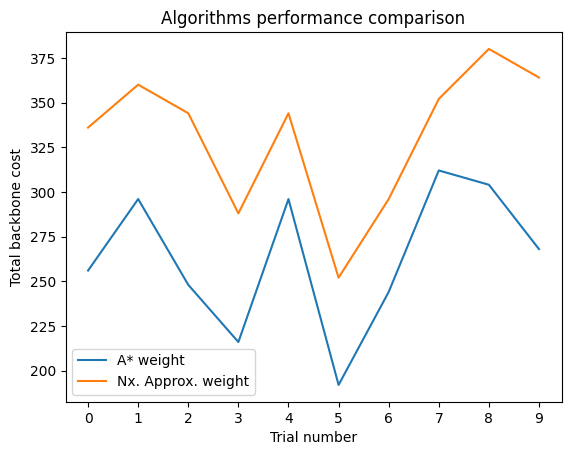

In [24]:
results_df[["A* weight", "Nx. Approx. weight"]].plot.line(
    title="Algorithms performance comparison",
    xlabel="Trial number",
    ylabel="Total backbone cost",
    xticks=[_ for _ in range(len(results_df))]
)